# Logistic regression with Class weighting implementation
Date: 10/01/2022

In [1]:
import findspark
findspark.init()

In [2]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

### Generate Data with make_blobs

In [4]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 4 # max iterations 
n=100000 # the number of total samples

ratio_positive = 0.01 # The classes ratio. We are crating a very imbalanced dataset.
n_samples = [int(n*(1-ratio_positive)), int(n*ratio_positive)]
n_components = [1,1]
n_samples

[99000, 1000]

In [5]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n_samples, # the number of total samples
                  centers=None, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = 1.5, # the std of each cluster
                  random_state=2) # 2

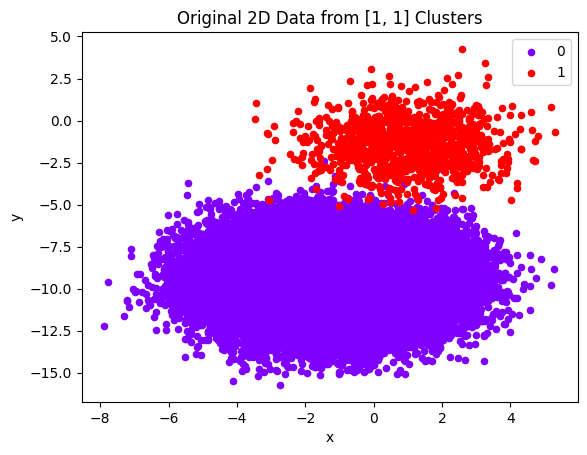

In [6]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

# Class Weights Calculation
In machine learning, it is often important to consider class imbalances when training a model. Class imbalance occurs when the number of samples in different classes of the target variable varies significantly. This can lead to biased model performance, as the model may prioritize the majority class and overlook the minority class. To address this issue, one approach is to assign weights to each class based on their sample sizes.

## Class Weights Calculation
To calculate the weights of the classes, we can use the following formula:

$$w_j = \frac{n_{\text{samples}}}{n_{\text{classes}} \times n_{\text{samples}_j}}$$

Where:
- $w_j$ is the weight for each class, with 'j' representing the class.
- $n_{\text{samples}}$ is the total number of samples or rows in the dataset.
- $n_{\text{classes}}$ is the total number of unique classes in the target.
- $n_{\text{samples}_j}$ is the total number of rows of the respective class.

The intuition behind this formula is to assign higher weights to classes with fewer samples, thus giving them more importance during model training.

## Example
Let's consider a dataset with the following information:
- Total number of samples ($n_{\text{samples}}$): 1000
- Total number of classes ($n_{\text{classes}}$): 5
- Number of samples for each class ($n_{\text{samples}_j}$):
    - Class A: 200
    - Class B: 300
    - Class C: 150
    - Class D: 100
    - Class E: 250

Using the formula, we can calculate the weights for each class:

$$w_{\text{Class A}} = \frac{1000}{5 \times 200} = 1$$
$$w_{\text{Class B}} = \frac{1000}{5 \times 300} = 0.333$$
$$w_{\text{Class C}} = \frac{1000}{5 \times 150} = 1.333$$
$$w_{\text{Class D}} = \frac{1000}{5 \times 100} = 2$$
$$w_{\text{Class E}} = \frac{1000}{5 \times 250} = 0.8$$

## Conclusion
Calculating class weights is a useful technique to handle class imbalances in machine learning. By assigning higher weights to classes with fewer samples, we ensure that the model gives equal importance to each class during training. This helps in improving the model's performance on minority classes and overall predictive accuracy.

## Class Weights Calculation for Binary Classification
In binary classification, class imbalance refers to a situation where the number of samples in one class significantly exceeds the number of samples in the other class. This can lead to biased model performance, as the model may struggle to properly learn and classify the minority class. To address this issue, assigning appropriate weights to the classes can help balance the impact of each class during model training.

## Class Weights Calculation
To calculate the weights of the classes, we can use the following formula:

$$w_j = \frac{n_{\text{samples}}}{n_{\text{classes}} \times n_{\text{samples}_j}}$$

Where:
- $w_j$ is the weight for each class, with 'j' representing the class.
- $n_{\text{samples}}$ is the total number of samples or rows in the dataset.
- $n_{\text{classes}}$ is the total number of unique classes in the target.
- $n_{\text{samples}_j}$ is the total number of rows of the respective class.

The intuition behind this formula is to assign higher weights to classes with fewer samples, thus giving them more importance during model training.

## Example
Let's consider a binary classification dataset with the following information:
- Total number of samples $n_{\text{samples}}= 1000$
- Number of unique classes $n_{\text{classes}} = 2$
- Number of samples in the negative class $n_{\text{samples}_0}= 800$
- Number of samples in the positive class $n_{\text{samples}_1}= 200$

Using the formula, we can calculate the class weights:

$$w_0 = \frac{1000}{2*800} = 0.625$$
$$w_1 = \frac{1000}{2*200} = 2.5$$

In this case, we assign a higher weight of 2.5 to the positive class (class 1) and a lower weight of 0.625 to the negative class (class 0). This ensures that the model gives equal importance to both classes during training, thus improving its performance on the minority class.

In [7]:
w0 = n/(2*n_samples[0])
w1 = n/(2*n_samples[1])
print(w0,w1)

0.5050505050505051 50.0


#### Prepare the data in RDD

In [8]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
# Add: map(lambda x: (x[0],np.append(x[1],1)))
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.8, 0.2], seed=12345)
traindata.cache()

traindata1 = traindata.map(lambda x: (x[0],np.append(x[1],1)))
traindata1.cache()
train_size = traindata1.count()
print(traindata1.take(1))

[(0, array([-3.02457665, -9.92809418,  1.        ]))]


#### The standard Logistic Regression

In [9]:
# The standard version of the code
def LogisticRegression_optimized(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta = 0.9,
                       beta2 = 0.999,
                       optimizer = 'SGD',  #optimizer: 'Momentum' / 'Adam' / 'Nesterov' / 'Adagrad' / 'RMSprop' / 'SGD' 
                       train_size=1
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    
    parameter_size = len(traindata.take(1)[0][1])

    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)
    momentum = np.zeros(parameter_size)
    prev_mom = np.zeros(parameter_size)
    second_mom = np.array(parameter_size)
    gti = np.zeros(parameter_size)
    epsilon = 10e-8
    
    for i in range(max_iteration):

        bc_weights = parameter_vector
        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (y[1]) * (-y[0] + (1/(np.exp(-np.dot(y[1], bc_weights))+1))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights))) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights))),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))        

        # Optimise
        gradients = res[0]
        sum_cost = res[1]
        num_samples = res[2]
        cost =  sum_cost/num_samples + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / num_samples) * gradients + 2 * regularization * parameter_vector
        
        if optimizer == 'SGD':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='Momentum':
            momentum = beta * momentum + learningRate * gradient_derivative
            parameter_vector = parameter_vector - momentum
            
        if optimizer == 'Nesterov':
            parameter_temp = parameter_vector - beta * prev_mom
            parameter_vector = parameter_temp - learningRate * gradient_derivative
            prev_mom = momentum
            momentum = beta * momentum + learningRate * gradient_derivative
            
        if optimizer == 'Adam':
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            second_mom = beta2 * second_mom + (1 - beta2) * (gradient_derivative**2)
            momentum_ = momentum / (1 - beta**(i + 1))
            second_mom_ = second_mom / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum_ / (np.sqrt(second_mom_) + epsilon)

        if optimizer == 'Adagrad':
            gti += gradient_derivative**2
            adj_grad = gradient_derivative / (np.sqrt(gti)  + epsilon)
            parameter_vector = parameter_vector - learningRate  * adj_grad
        
        if optimizer == 'RMSprop':
            sq_grad = gradient_derivative**2
            exp_grad = beta * gti / (i + 1) + (1 - beta) * sq_grad
            parameter_vector = parameter_vector - learningRate / np.sqrt(exp_grad + epsilon) * gradient_derivative
            gti += sq_grad
            
            
        print("Iteration No.", i, " Cost=", cost, "graients=",gradients)
        
        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

#### Weighted Logistic Regression

In [10]:
def LogisticRegression_weighted(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta = 0.9,
                       beta2 = 0.999,
                       optimizer = 'SGD',  #optimizer: 'Momentum' / 'Adam' / 'Nesterov' / 'Adagrad' / 'RMSprop' / 'SGD' 
                       train_size=1
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    
    parameter_size = len(traindata.take(1)[0][1])
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)
    momentum = np.zeros(parameter_size)
    prev_mom = np.zeros(parameter_size)
    second_mom = np.array(parameter_size)
    gti = np.zeros(parameter_size)
    epsilon = 10e-8
    
    for i in range(max_iteration):

        bc_weights = parameter_vector
        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)
  
        # treeAggregate(vector of gradients, total_cost, number_of_samples)
        # Calcualtion of positive class. Only the samples labeled as 1 are filtered and then  processed
        res1 = min_batch.filter(lambda x: x[0]==1).treeAggregate(
              (np.zeros(parameter_size), 0, 0),
              lambda x, y:(x[0]+\
                          (y[1])*(-y[0]+(1/(np.exp(-np.dot(y[1], bc_weights))+1))),\
                          x[1]+\
                          y[0]*(-(np.dot(y[1], bc_weights)))+np.log(1 + np.exp(np.dot(y[1],bc_weights))),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2])
              )        
        # Calcualtion of negative class. Only the samples labeled as 0 are filtered and then processed
        res0 = min_batch.filter(lambda x: x[0]==0).treeAggregate(
              (np.zeros(parameter_size), 0, 0),
              lambda x, y:(x[0]+\
                          (y[1])*(-y[0]+(1/(np.exp(-np.dot(y[1], bc_weights))+1))),\
                          x[1]+\
                          y[0]*(-(np.dot(y[1], bc_weights)))+np.log(1 + np.exp(np.dot(y[1],bc_weights))),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2])
              )        
        
        # The total gradients are a weighted sum
        gradients = w0*res0[0]+w1*res1[0]
        sum_cost = w0*res0[1]+w1*res1[1]
        num_samples = res0[2]+res1[2]
        
        cost =  sum_cost/num_samples + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / num_samples) * gradients + 2 * regularization * parameter_vector
        
        if optimizer == 'SGD':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='Momentum':
            momentum = beta * momentum + learningRate * gradient_derivative
            parameter_vector = parameter_vector - momentum
            
        if optimizer == 'Nesterov':
            parameter_temp = parameter_vector - beta * prev_mom
            parameter_vector = parameter_temp - learningRate * gradient_derivative
            prev_mom = momentum
            momentum = beta * momentum + learningRate * gradient_derivative
            
        if optimizer == 'Adam':
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            second_mom = beta2 * second_mom + (1 - beta2) * (gradient_derivative**2)
            momentum_ = momentum / (1 - beta**(i + 1))
            second_mom_ = second_mom / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum_ / (np.sqrt(second_mom_) + epsilon)

        if optimizer == 'Adagrad':
            gti += gradient_derivative**2
            adj_grad = gradient_derivative / (np.sqrt(gti)  + epsilon)
            parameter_vector = parameter_vector - learningRate  * adj_grad
        
        if optimizer == 'RMSprop':
            sq_grad = gradient_derivative**2
            exp_grad = beta * gti / (i + 1) + (1 - beta) * sq_grad
            parameter_vector = parameter_vector - learningRate / np.sqrt(exp_grad + epsilon) * gradient_derivative
            gti += sq_grad
            
            
        print("Iteration No.", i, " Cost=", cost, "graients=",gradients)
        
        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

#### Train using Weigthed model

In [11]:
# Call to the original function
parameter_vector_sgd_w, L_cost_sgd_w = LogisticRegression_weighted(traindata=traindata1,
                       max_iteration = 20,
                       learningRate = 0.01,
                       regularization = 0,
                       mini_batch_size = 50000,
                       tolerance = 10e-8,
                       optimizer = 'RMSprop',
                      )

Iteration No. 0  Cost= 0.5444083217357665 graients= [ -31201.59377083 -117068.91882609   -3103.65624296]
Iteration No. 1  Cost= 0.4903000740836418 graients= [-26670.57565798 -90785.56125139  -5579.53988256]
Iteration No. 2  Cost= 0.47316261944109544 graients= [-25199.74948646 -83279.25844109  -6186.47073437]
Iteration No. 3  Cost= 0.458922953896996 graients= [-23948.90916534 -76578.67131719  -6755.83510642]
Iteration No. 4  Cost= 0.44639976063122333 graients= [-22833.78798316 -70595.31815954  -7261.70058317]
Iteration No. 5  Cost= 0.43516072456262644 graients= [-21822.04911898 -65209.53226919  -7710.39871798]
Iteration No. 6  Cost= 0.4249638157556091 graients= [-20895.60438347 -60339.88898409  -8108.26305416]
Iteration No. 7  Cost= 0.4156445950662801 graients= [-20042.09910987 -55924.76916227  -8460.73634796]
Iteration No. 8  Cost= 0.4070794046261979 graients= [-19252.13025463 -51913.96679909  -8772.53640517]
Iteration No. 9  Cost= 0.3991698751566547 graients= [-18518.1036417  -48264.8

#### Train using standard model

In [12]:
# Call of the optimzed function wiht the same parameters
parameter_vector_sgd, L_cost_sgd = LogisticRegression_optimized(traindata=traindata1,
                       max_iteration = 20,
                       learningRate = 0.01,
                       regularization = 0,
                       mini_batch_size = 50000,
                       tolerance = 10e-8,
                       optimizer = 'RMSprop',
                       train_size = train_size
                      )

Iteration No. 0  Cost= 0.4809999126603584 graients= [ -19635.7718688  -176091.62976705   18486.64656711]
Iteration No. 1  Cost= 0.3608912571083019 graients= [ -14401.41099418 -138338.96298425   14561.84234888]
Iteration No. 2  Cost= 0.32655948948720975 graients= [ -12700.29326845 -125957.97317614   13261.24054832]
Iteration No. 3  Cost= 0.29797067152299817 graients= [ -11473.34608183 -115875.31060548   12226.55135998]
Iteration No. 4  Cost= 0.27427632764295345 graients= [ -10394.28316154 -107801.70613718   11385.85587071]
Iteration No. 5  Cost= 0.25268935402130677 graients= [ -9410.10241405 -99173.74821336  10474.29403372]


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task serialization failed: java.nio.file.NoSuchFileException: C:\Users\dimit\AppData\Local\Temp\blockmgr-594e64b1-a2e6-4879-a237-f6dc7e376972\19
java.nio.file.NoSuchFileException: C:\Users\dimit\AppData\Local\Temp\blockmgr-594e64b1-a2e6-4879-a237-f6dc7e376972\19
	at sun.nio.fs.WindowsException.translateToIOException(WindowsException.java:79)
	at sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:97)
	at sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:102)
	at sun.nio.fs.WindowsFileSystemProvider.createDirectory(WindowsFileSystemProvider.java:508)
	at java.nio.file.Files.createDirectory(Files.java:674)
	at org.apache.spark.storage.DiskBlockManager.getFile(DiskBlockManager.scala:96)
	at org.apache.spark.storage.DiskStore.remove(DiskStore.scala:114)
	at org.apache.spark.storage.BlockManager.removeBlockInternal(BlockManager.scala:1952)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1435)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.putIterator(BlockManager.scala:1327)
	at org.apache.spark.storage.BlockManager.putSingle(BlockManager.scala:1816)
	at org.apache.spark.broadcast.TorrentBroadcast.writeBlocks(TorrentBroadcast.scala:135)
	at org.apache.spark.broadcast.TorrentBroadcast.<init>(TorrentBroadcast.scala:95)
	at org.apache.spark.broadcast.TorrentBroadcastFactory.newBroadcast(TorrentBroadcastFactory.scala:34)
	at org.apache.spark.broadcast.BroadcastManager.newBroadcast(BroadcastManager.scala:74)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1515)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1478)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1307)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1249)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2592)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1488)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1307)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1249)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2592)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor48.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.nio.file.NoSuchFileException: C:\Users\dimit\AppData\Local\Temp\blockmgr-594e64b1-a2e6-4879-a237-f6dc7e376972\19
	at sun.nio.fs.WindowsException.translateToIOException(WindowsException.java:79)
	at sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:97)
	at sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:102)
	at sun.nio.fs.WindowsFileSystemProvider.createDirectory(WindowsFileSystemProvider.java:508)
	at java.nio.file.Files.createDirectory(Files.java:674)
	at org.apache.spark.storage.DiskBlockManager.getFile(DiskBlockManager.scala:96)
	at org.apache.spark.storage.DiskStore.remove(DiskStore.scala:114)
	at org.apache.spark.storage.BlockManager.removeBlockInternal(BlockManager.scala:1952)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1435)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.putIterator(BlockManager.scala:1327)
	at org.apache.spark.storage.BlockManager.putSingle(BlockManager.scala:1816)
	at org.apache.spark.broadcast.TorrentBroadcast.writeBlocks(TorrentBroadcast.scala:135)
	at org.apache.spark.broadcast.TorrentBroadcast.<init>(TorrentBroadcast.scala:95)
	at org.apache.spark.broadcast.TorrentBroadcastFactory.newBroadcast(TorrentBroadcastFactory.scala:34)
	at org.apache.spark.broadcast.BroadcastManager.newBroadcast(BroadcastManager.scala:74)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1515)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1478)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1307)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1249)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2592)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)


#### Prepare test dataset

In [12]:
# Test data need to be in the same format as the train data
testdata1 = testdata.map(lambda x: (x[0],np.append(x[1],1)))
test_num = testdata1.count()
testdata1.take(3)

[(0, array([ -0.9911372 , -10.01991492,   1.        ])),
 (0, array([ 0.74630673, -8.24840199,  1.        ])),
 (0, array([ -2.16338454, -12.02110725,   1.        ]))]

In [13]:
# Parameter vector size and test sample size must match.
print(parameter_vector_sgd, parameter_vector_sgd_w)

[ 0.32493528  0.20574032 -0.0680822 ] [0.36890242 0.20178211 0.3839993 ]


#### Performance od the weighted model

In [14]:
# Create an RDD wiht the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],parameter_vector_sgd_w)>0 else 0))

# predictions = (1, 1) (0, 1) ...
#               1 , 0, 

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:   134  FP:    12
 FN:    44  TN: 19785
----------------------
Accuracy = 0.9971964956195244  
F1 = 0.8271604938271605


#### Performance of the standard model

In [15]:
# Create an RDD wiht the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],parameter_vector_sgd)>0 else 0))

# predictions = (1, 1) (0, 1) ...
#               1 , 0, 

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:    85  FP:     0
 FN:    93  TN: 19797
----------------------
Accuracy = 0.9953441802252816  
F1 = 0.6463878326996197
